# **Ритмы продаж**

### **Задание:**
Постройте модель, которая для каждой пары товар-день в тестовом периоде предскажет точное количество проданных единиц товара.

### **Данные:**
- `train.parquet` - история продаж за определенный период.
- `test.parquet` - данные за 14 дней, следующих сразу за обучающим набором.
- `sample_submission.csv` - файл-шаблон для отправки вашего решения.

### **Файлы train.parquet и test.parquet содержат:**
- `nm_id` - анонимный идентификатор товара.
- `dt` - дата.
- `price` - цена товара в этот день.
- `is_promo` - флаг участия товара в промо-акции.
- `prev_leftovers` - остаток товара на складе на начало дня.
- `qty` - количество проданных единиц, присутствует только в train. Это ваш таргет.

### **Метрика:**

Качество вашего решения будет оцениваться с помощью метрики взвешенной MAE (wMAE). Так как в данных много дней с нулевыми продажами, мы усиливаем вклад дней, когда продажи были, ведь ошибка в них критичнее.
Веса определяются следующим образом:

$$ w_i =
\begin{cases}
1, & \text{если } y_i = 0 \\
7, & \text{если } y_i > 0
\end{cases}
$$

Итоговая формула метрики:

$$wMAE = \frac{\sum_{i} w_i \cdot |y_i - \hat{y}_i|}{\sum_{i} w_i},$$

где $y_i$  — истинное значение продаж, а $\hat{y}_i$  — ваш прогноз.

Примечание. Вес для дней с продажами $w_{pos} = 7$ был выбран не случайно. Он рассчитан по обучающей выборке так, чтобы сбалансировать общую сумму весов для обоих классов, исходя из доли дней с продажами
$p ≈ 0.13$.

##  **Постановка гипотез**

**1. Лаговые признаки и скользящие окна.** Лаги продаж (1, 2, 3, 7, 14 дней) и скользящие средние (3-, 7-, 14-дневные) значительно улучшают прогноз, так как продажи имеют автокорреляцию.

**2. Ценовые признаки и эластичность спроса.** Цена и её относительные изменения (price_change, price/median_price_nm) критически влияют на продажи — снижение цены повышает вероятность покупки.

**3. Промо-акции и их отложенный эффект.** Признак `is_promo` и его лаги (вчера была акция, длина цепочки промо) повышают продажи и улучшают прогноз качества.

**4. Календарные и сезонные признаки.** Добавление календарных признаков (день недели, месяц, тригонометрическая сезонность sin/cos) улучшит метрику, т.к. спрос цикличен (например, кроссовки летом).

**5. Остатки товара (prev_leftovers).** `prev_leftovers` и изменение остатков (`delta_leftovers`) помогают предсказывать отсутствие продаж (out of stock) и влияют на величину `qty`.

**6. Двухступенчатая модель (Zero-Inflated Sales).** Поскольку в данных много нулевых продаж, двухступенчатая модель — классификатор (продажа / нет) + регрессор (количество при продаже) — даст более низкий wMAE, чем единая регрессия.

**7. Кластеризация товаров по паттернам продаж.** Разделение товаров на группы (сезонные, стабильные) и добавление кластера как фичи позволит модели точнее улавливать паттерны и снизит ошибку.




# **Exploratory data analysis (EDA)**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import lightgbm as lgb
from lightgbm import LGBMRegressor


In [5]:
df_train = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')
sub = pd.read_csv('sample_submission.csv')

**Общая информация о данных:**

In [6]:
df_train.head(5)

,nm_id,dt,qty,price,is_promo,prev_leftovers
0,015ecac1-0d4d-4272-9f9c-7c62a742a679,2024-07-04,0,2940,0,54
1,02790618-93a6-4a2e-92e2-72cbb0bf24cf,2024-07-04,3,6543,0,75
2,03cf7d0c-4709-409d-a964-44558ada7e3d,2024-07-04,3,4983,0,66
3,0407f293-33e5-4c34-8236-9ddef5a166f0,2024-07-04,3,1971,1,132
4,046336e9-58cd-4d0f-b521-c70607fd9ec4,2024-07-04,0,2133,1,87


In [7]:
df_train.shape, df_test.shape

((309648, 6), (12856, 5))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309648 entries, 0 to 309647
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nm_id           309648 non-null  object        
 1   dt              309648 non-null  datetime64[ns]
 2   qty             309648 non-null  int64         
 3   price           309648 non-null  int64         
 4   is_promo        309648 non-null  int64         
 5   prev_leftovers  309648 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 14.2+ MB


In [9]:
df_train.describe().round(2)

,dt,qty,price,is_promo,prev_leftovers
count,309648,309648.00,309648.00,309648.00,309648.00
mean,2024-12-21 13:39:55.442567168,0.85,9160.02,0.49,71.87
min,2024-07-04 00:00:00,0.00,48.00,0.00,9.00
25%,2024-09-23 00:00:00,0.00,4167.00,0.00,12.00
50%,2024-12-12 00:00:00,0.00,6870.00,0.00,24.00
75%,2025-03-19 00:00:00,0.00,11445.00,1.00,57.00
max,2025-07-07 00:00:00,294.00,87798.00,1.00,9063.00
std,NaN,4.89,7844.79,0.50,204.02


In [10]:
print(f'Пропуски в df_train = {sum(~df_train.any())}, df_test = {sum(~df_test.any())}')

Пропуски в df_train = 0, df_test = 0


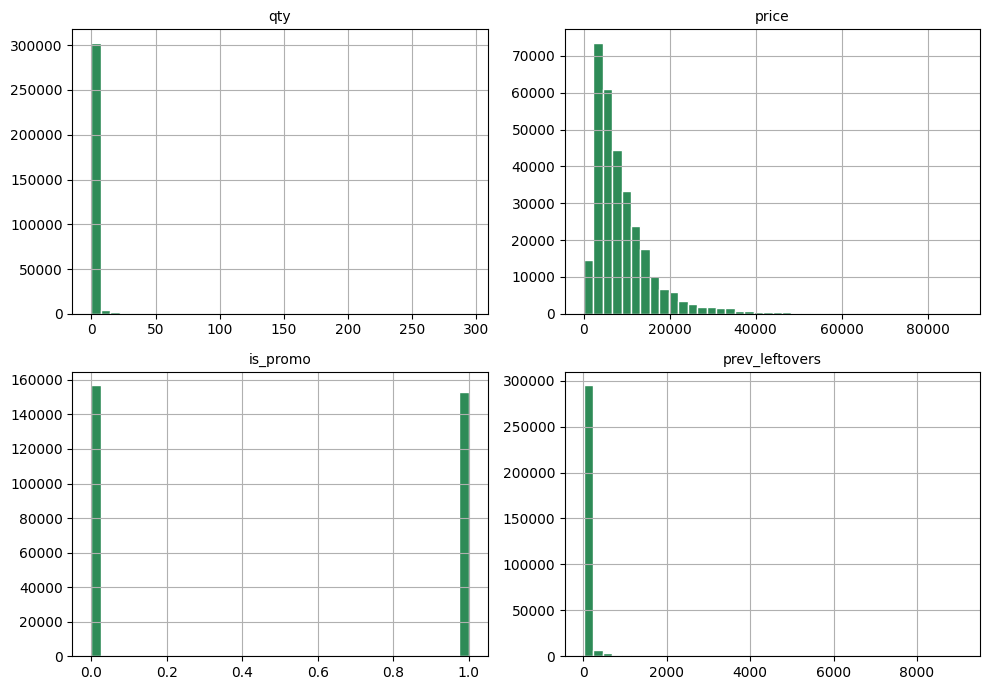

In [11]:
columns_name = df_train.columns[2:]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes =axes.flatten()

for i, col in enumerate(columns_name):
  df_train[col].hist(bins=40, ax=axes[i], color='seagreen', edgecolor='white')
  axes[i].set_title(col, fontsize=10)

plt.tight_layout()
plt.show()

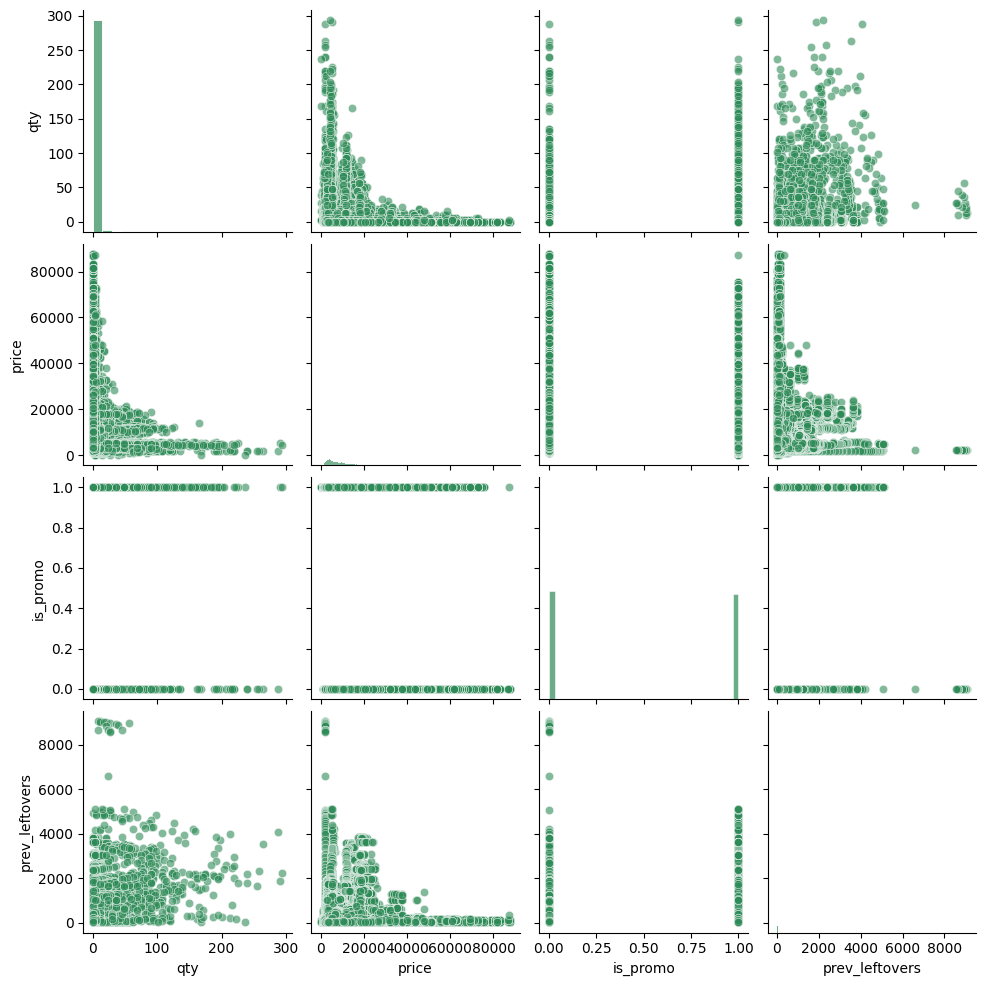

In [12]:
sns.pairplot(df_train,
             plot_kws={'color': 'seagreen', 'edgecolor': 'white', 'alpha': 0.6},
             diag_kws={'color': 'seagreen', 'edgecolor': 'white', 'alpha': 0.7})

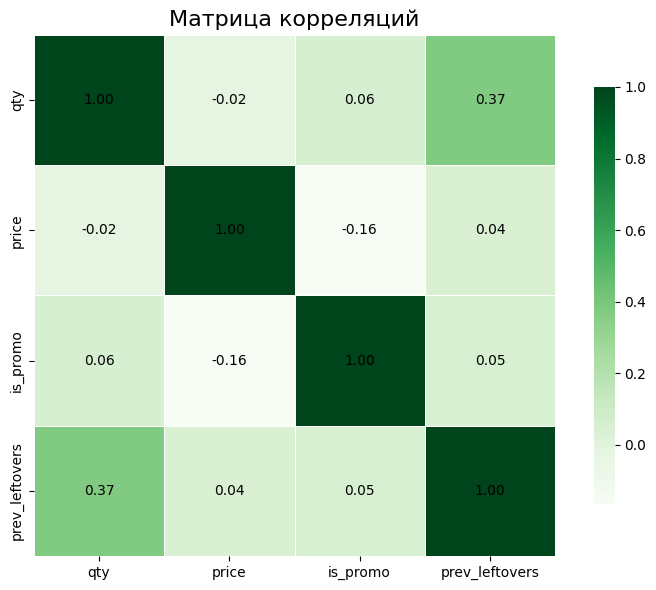

In [13]:
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
corr_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Greens', square=True,
            linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8},
            annot_kws={'color': 'black', 'size': 10})
plt.title('Матрица корреляций', fontsize=16)
plt.tight_layout()
plt.show()

## **Анализ `nm_id` - анонимный идентификатор товара**

In [14]:
#Уникальных товаров:
len(df_train['nm_id'].unique())

2743

In [15]:
daily_sales = df_train.groupby('dt')['qty'].sum().reset_index()
daily_sales.columns = ['date', 'total_sales']

product_days = df_train.groupby('nm_id').agg(
    days_with_sales=('qty', lambda x: (x > 0).sum()),
    total_days=('dt', 'count')
).reset_index()

product_days['percent_without'] = ((product_days['total_days'] - product_days['days_with_sales']) / product_days['total_days']) * 100

print(f'Средний процент дней без продаж: {product_days["percent_without"].mean():.2f}%')

Средний процент дней без продаж: 79.08%


## **Анализ `dt` - дата**

In [16]:
print('df_train:')
print(f'Дата начала {min(df_train["dt"])}')
print(f'Дата конца {max(df_train["dt"])}')
print(f'Всего дней {(max(df_train["dt"]) - min(df_train["dt"])).days + 1}')

print('df_test:')
print(f'Дата начала {min(df_test["dt"])}')
print(f'Дата конца {max(df_test["dt"])}')
print(f'Всего дней {(max(df_test["dt"]) - min(df_test["dt"])).days + 1}')

df_train:
Дата начала 2024-07-04 00:00:00
Дата конца 2025-07-07 00:00:00
Всего дней 369
df_test:
Дата начала 2025-07-08 00:00:00
Дата конца 2025-07-21 00:00:00
Всего дней 14


## **Анализ `qty` - количество проданных единиц**


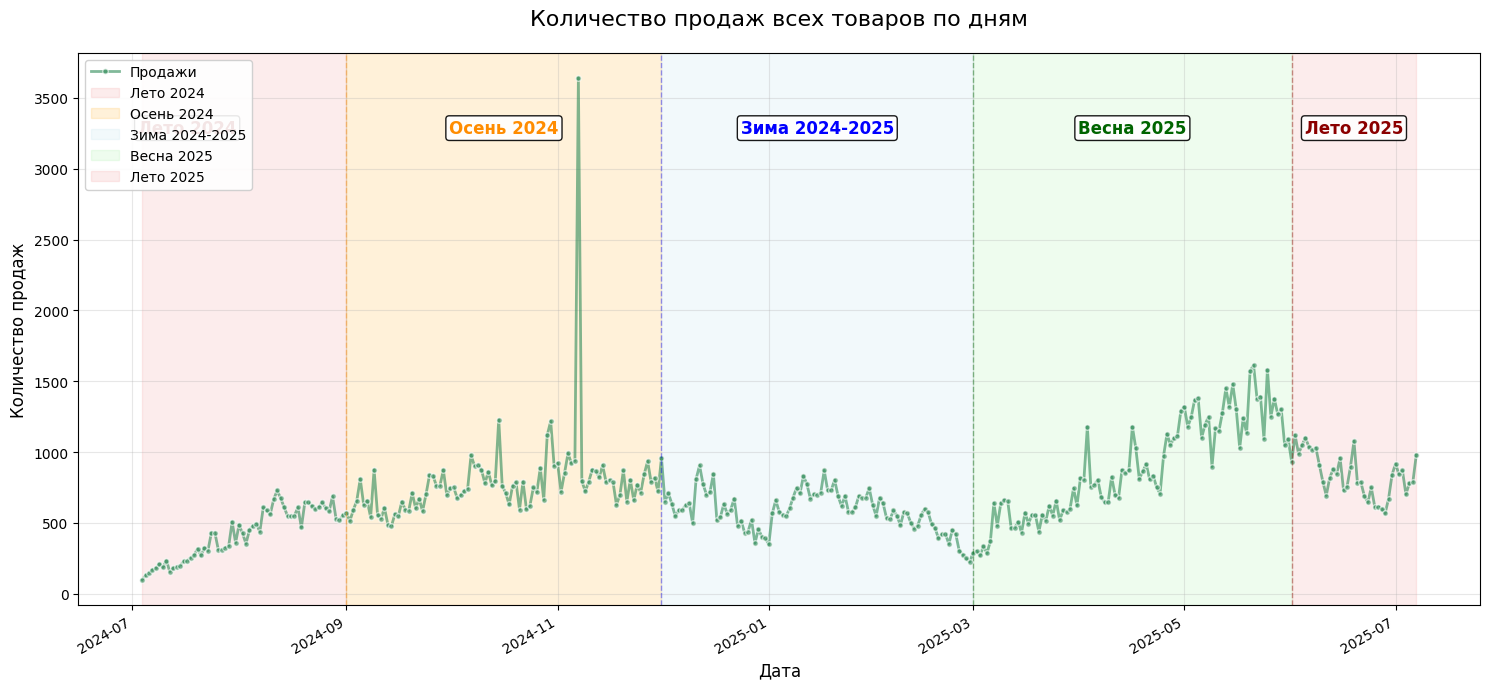

In [17]:
daily_sales = df_train.groupby('dt')['qty'].sum().reset_index()
daily_sales.columns = ['date', 'total_sales']

plt.figure(figsize=(15, 7))

plt.plot(daily_sales['date'], daily_sales['total_sales'], color='seagreen',
         marker='o', markersize=4, markeredgecolor='white',
         markerfacecolor='seagreen', linewidth=2, alpha=0.6, label='Продажи')

season_periods = [
    ('Лето 2024', '2024-06-01', '2024-09-01', 'lightcoral', 'darkred'),
    ('Осень 2024', '2024-09-01', '2024-12-01', 'orange', 'darkorange'),
    ('Зима 2024-2025', '2024-12-01', '2025-03-01', 'lightblue', 'blue'),
    ('Весна 2025', '2025-03-01', '2025-06-01', 'lightgreen', 'darkgreen'),
    ('Лето 2025', '2025-06-01', '2025-09-01', 'lightcoral', 'darkred')
]

data_start = daily_sales['date'].min()
data_end = daily_sales['date'].max()
ymin, ymax = daily_sales['total_sales'].min(), daily_sales['total_sales'].max()


added_labels = set()
for season_name, start_date, end_date, fill_color, line_color in season_periods:
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    if start_dt <= data_end and end_dt >= data_start:
        plot_start = max(start_dt, data_start)
        plot_end = min(end_dt, data_end)

        if season_name not in added_labels:
            plt.axvspan(plot_start, plot_end, alpha=0.15, color=fill_color, label=season_name)
            added_labels.add(season_name)
        else:
            plt.axvspan(plot_start, plot_end, alpha=0.15, color=fill_color)

        if start_dt >= data_start and start_dt <= data_end:
            plt.axvline(x=start_dt, color=line_color, linestyle='--', alpha=0.4, linewidth=1)

        mid_point = start_dt + (end_dt - start_dt)/2
        if mid_point < data_start:
            mid_point = data_start + (plot_end - data_start)/2
        elif mid_point > data_end:
            mid_point = plot_start + (data_end - plot_start)/2

        plt.text(mid_point, ymax * 0.92, season_name,
                horizontalalignment='center', verticalalignment='top',
                color=line_color, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9))

last_end = pd.to_datetime('2025-09-01')
if last_end <= data_end:
    plt.axvline(x=last_end, color='darkred', linestyle='--', alpha=0.4, linewidth=1)

plt.title('Количество продаж всех товаров по дням', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='upper left', framealpha=0.9)

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [18]:
wb_sales = [
    ('День рождения WB', '2024-10-07', '2024-10-20', '#8B4513', 0.15),
    ('День шоппинга', '2024-11-01', '2024-11-14', '#4169E1', 0.15),
    ('Чёрная пятница', '2024-11-21', '2024-12-04', '#DC143C', 0.2),
    ('Киберпонедельник', '2024-12-02', '2024-12-04', '#8B0000', 0.15),
    ('Новогодняя', '2024-12-12', '2025-01-09', '#2E8B57', 0.15)
]
events = [
    ('11.11', '2024-11-11', 0.95),
    ('23 февраля', '2025-02-23', 0.95),
    ('8 марта', '2025-03-08', 0.95),
    ('Новогодняя', '2024-12-20', 0.88),
    ('Весенняя', '2025-03-15', 0.88),
    ('Летняя', '2025-06-15', 0.88),
    ('Летний BF', '2025-07-15', 0.88),
    ('Новый год', '2025-01-01', 0.78),
    ('Рождество', '2025-01-07', 0.78),
    ('14 Февраля', '2025-02-14', 0.78),
    ('Масленица', '2025-02-28', 0.78),
    ('9 Мая', '2025-05-09', 0.78),
    ('1 Июня', '2025-06-01', 0.78),
    ('12 Июня', '2025-06-12', 0.78),
    ('Выпускные', '2025-06-21', 0.78)
]

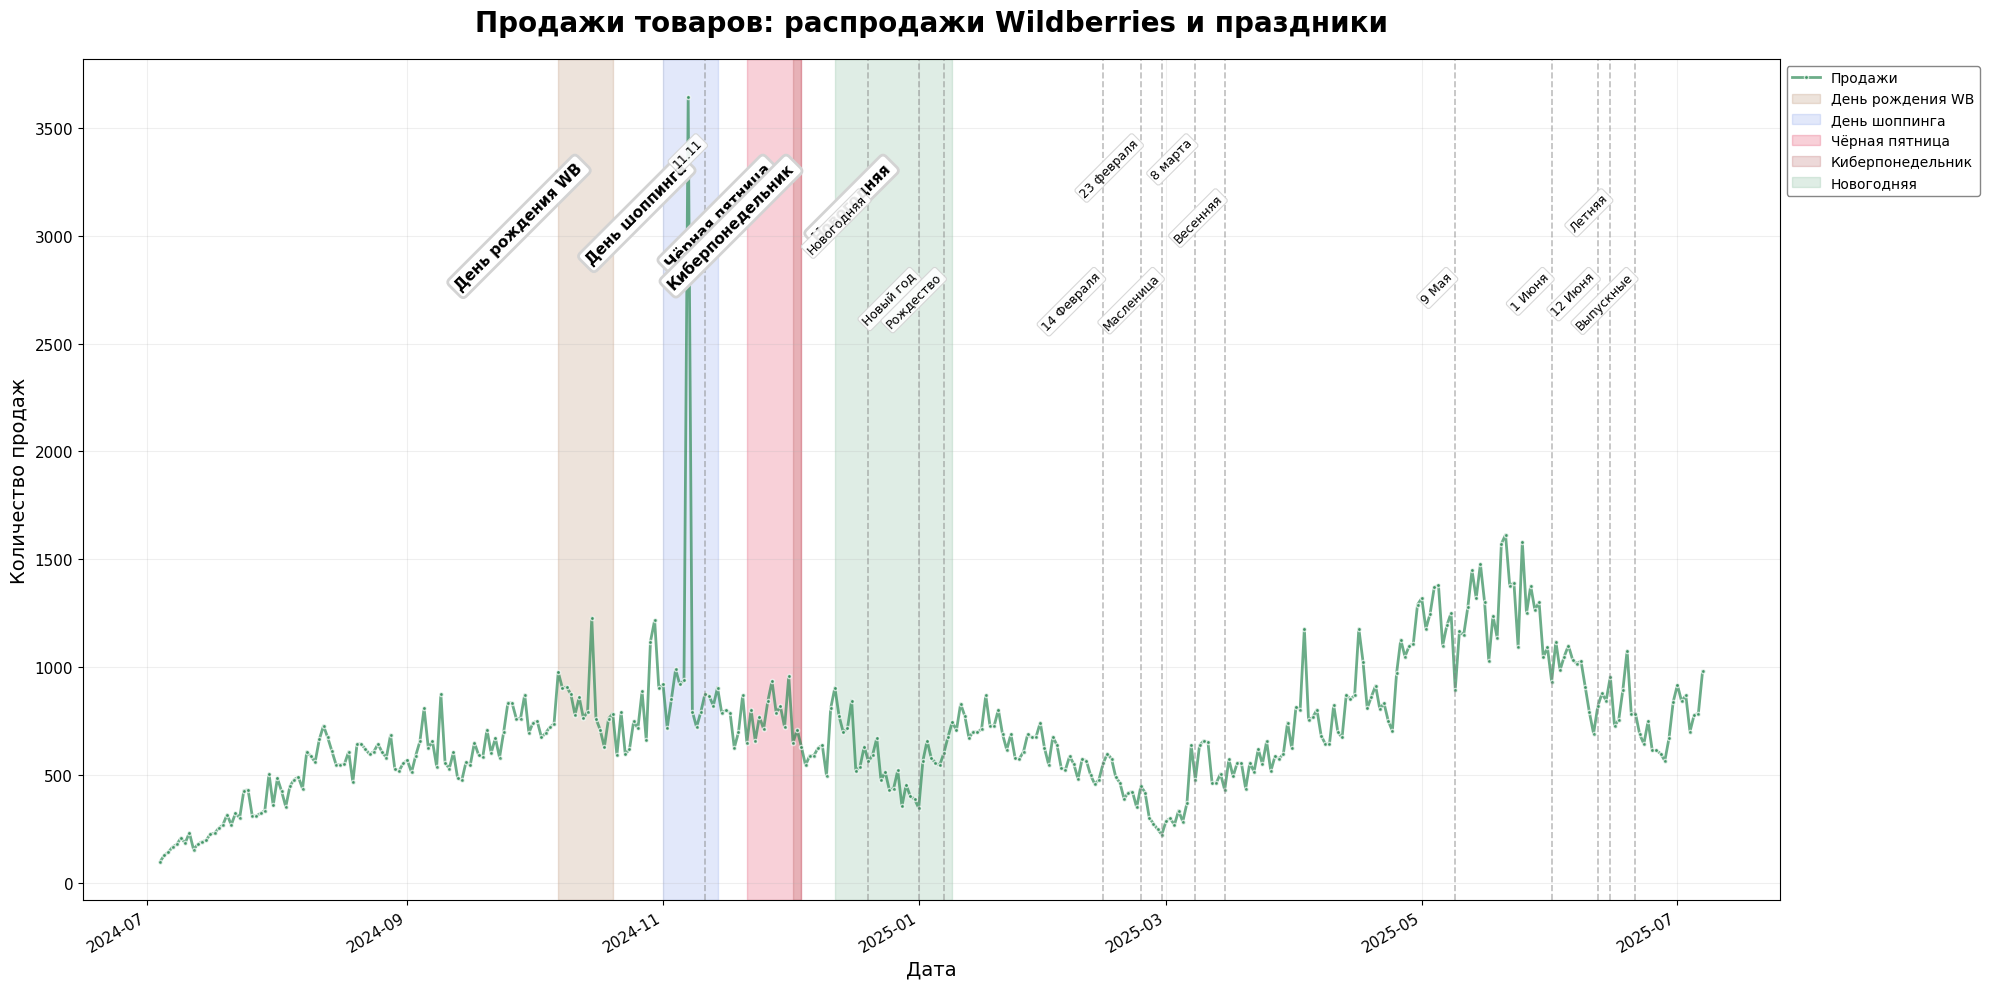

In [19]:
daily_sales = df_train.groupby('dt')['qty'].sum().reset_index()
daily_sales.columns = ['date', 'total_sales']

plt.figure(figsize=(20, 10))

plt.plot(daily_sales['date'], daily_sales['total_sales'],
         color='#2E8B57', marker='o', linewidth=2, markersize=3,
         markeredgecolor='white', alpha=0.7, label='Продажи')

for event, start, end, color, alpha in wb_sales:
    start_dt, end_dt = pd.to_datetime(start), pd.to_datetime(end)
    if end_dt >= daily_sales['date'].min() and start_dt <= daily_sales['date'].max():
        plot_start = max(start_dt, daily_sales['date'].min())
        plot_end = min(end_dt, daily_sales['date'].max())

        plt.axvspan(plot_start, plot_end, alpha=alpha, color=color, label=event)

        mid = plot_start + (plot_end - plot_start)/2
        plt.text(mid, daily_sales['total_sales'].max() * 0.92, event,
                rotation=45, ha='right', va='top',
                color='black', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='lightgray', linewidth=2))

for event, date, y_pos in events:
    date_dt = pd.to_datetime(date)
    if daily_sales['date'].min() <= date_dt <= daily_sales['date'].max():
        plt.axvline(x=date_dt, color='gray', linestyle='--', linewidth=1.2, alpha=0.5)
        plt.text(date_dt, daily_sales['total_sales'].max() * y_pos, event,
                rotation=45, va='top', ha='right',
                fontsize=9, color='black', fontweight='normal',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                         edgecolor='lightgray', linewidth=0.8, alpha=0.9))

plt.title('Продажи товаров: распродажи Wildberries и праздники',
         fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.grid(True, alpha=0.2)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), loc='upper left', bbox_to_anchor=(1, 1),
          framealpha=0.95, fontsize=10, frameon=True, edgecolor='gray')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [20]:
df = pd.DataFrame({
    'dt': pd.to_datetime(df_train['dt']),
    'qty': df_train['qty'],
    'year': df_train['dt'].dt.year,
    'month': df_train['dt'].dt.month,
    'quarter': df_train['dt'].dt.quarter,
    'weekday': df_train['dt'].dt.weekday,
    'week': df_train['dt'].dt.isocalendar().week
})

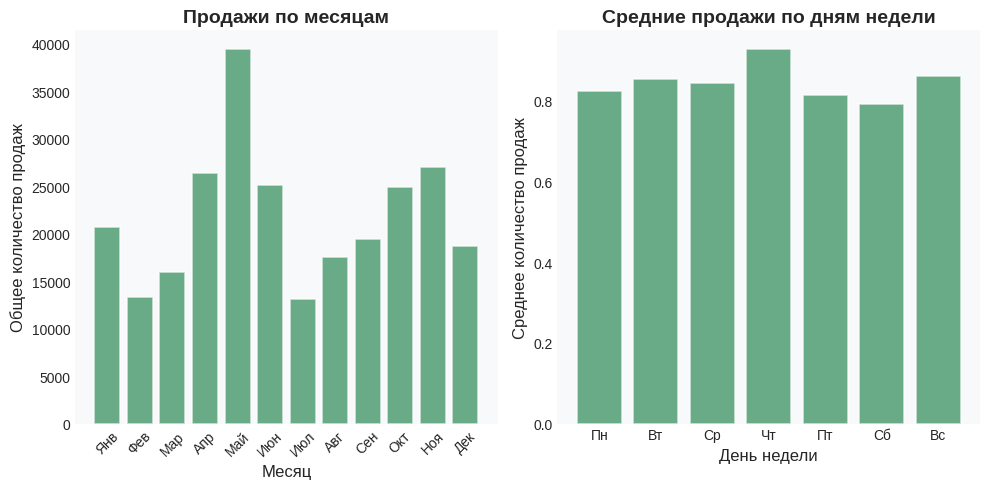

In [22]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
bar_kws = {'color': 'seagreen', 'edgecolor': 'white', 'linewidth': 1.2, 'alpha': 0.7}

# Продажи по месяцам
monthly_sales = df.groupby('month')['qty'].sum()
axes[0].bar(range(1, 13), monthly_sales, **bar_kws)
axes[0].set_title('Продажи по месяцам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Месяц', fontsize=12)
axes[0].set_ylabel('Общее количество продаж', fontsize=12)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
                        'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], rotation=45)

# Средние продажи по дням недели
weekday_sales = df.groupby('weekday')['qty'].mean()
weekday_order = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
axes[1].bar(weekday_order, weekday_sales, **bar_kws)
axes[1].set_title('Средние продажи по дням недели', fontsize=14, fontweight='bold')
axes[1].set_xlabel('День недели', fontsize=12)
axes[1].set_ylabel('Среднее количество продаж', fontsize=12)

for ax in axes:
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

## **Анализ `price` - цена товара в этот день**

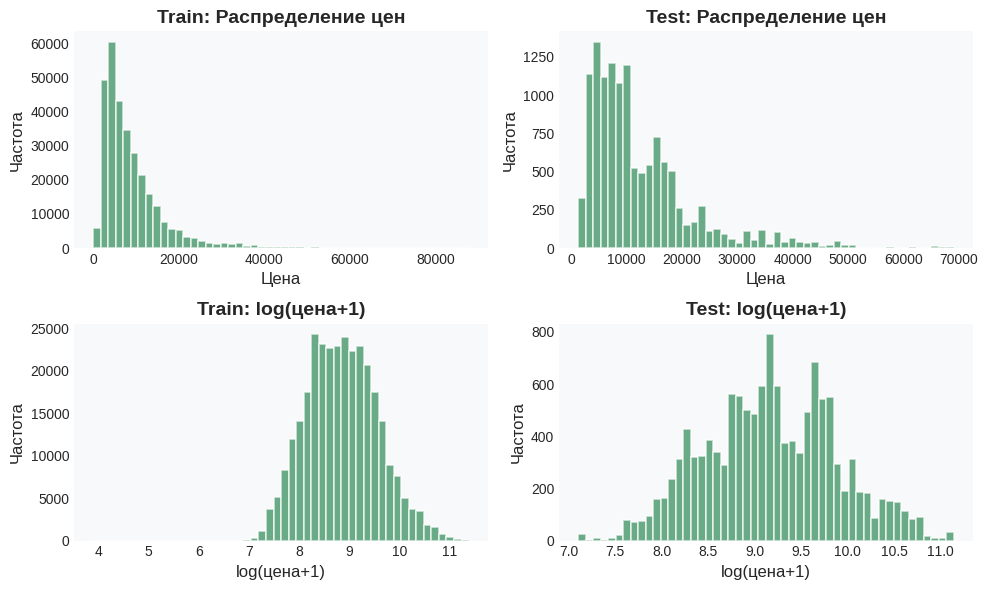

In [24]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
bar_kws = {'color': 'seagreen', 'edgecolor': 'white', 'linewidth': 1.2, 'alpha': 0.7}

# Гистограмма для train
axes[0, 0].hist(df_train['price'].dropna(), bins=50, **bar_kws)
axes[0, 0].set_title('Train: Распределение цен', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Цена', fontsize=12)
axes[0, 0].set_ylabel('Частота', fontsize=12)

# Гистограмма для test
axes[0, 1].hist(df_test['price'].dropna(), bins=50, **bar_kws)
axes[0, 1].set_title('Test: Распределение цен', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Цена', fontsize=12)
axes[0, 1].set_ylabel('Частота', fontsize=12)

# Логарифмическая шкала для train
axes[1, 0].hist(np.log1p(df_train['price'].dropna()), bins=50, **bar_kws)
axes[1, 0].set_title('Train: log(цена+1)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('log(цена+1)', fontsize=12)
axes[1, 0].set_ylabel('Частота', fontsize=12)

# Логарифмическая шкала для test
axes[1, 1].hist(np.log1p(df_test['price'].dropna()), bins=50, **bar_kws)
axes[1, 1].set_title('Test: log(цена+1)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('log(цена+1)', fontsize=12)
axes[1, 1].set_ylabel('Частота', fontsize=12)

# Применяем настройки сетки и фона как в примере
for ax in axes.flat:
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

## **Анализ `is_promo` - промо-акции**

In [25]:
promo_stats = df_train['is_promo'].value_counts()
print(f"Доля промо-дней: {promo_stats.get(1, 0)/len(df)*100:.2f}%")

Доля промо-дней: 49.36%


## **Анализ `prev_leftovers` - остаток товара**

In [26]:
corr_leftovers_qty = df_train[['prev_leftovers', 'qty']].corr().iloc[0, 1]
print(f"Корреляция между остатками и продажами: {corr_leftovers_qty:.2f}")

Корреляция между остатками и продажами: 0.37


# **Проверка гипотез**





In [27]:
# метрика
def weighted_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    w = np.where(y_true == 0, 1.0, 7.0)
    return (w * np.abs(y_true - y_pred)).sum() / w.sum()

In [28]:
# Загрузка данных
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

In [29]:
# Приведение типов
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

In [32]:
# Объединение обучающей и тестовой выборок
train['is_test'] = False
test['is_test'] = True
test['qty'] = np.nan  # в тесте таргета нет
full = pd.concat([train, test], axis=0, ignore_index=True).sort_values(['nm_id','dt']).reset_index(drop=True)
GROUP = full.groupby('nm_id', sort=False)


In [33]:
# Генерация признаков

## Лаги qty
for l in [1,2,3,7,14]:
    full[f'lag_qty_{l}'] = GROUP['qty'].shift(l)
##

## Скользящие средние (rolling on past days, closed left)
for w in [3,7,14]:
    full[f'roll_qty_mean_{w}'] = GROUP['qty'].shift(1).rolling(w,1).mean().reset_index(level=0, drop=True)
##

# Ценовые признаки и эластичность
## price lag and change
full['price_prev'] = GROUP['price'].shift(1)
full['price_change_rel'] = (full['price'] - full['price_prev']) / (full['price_prev'].replace(0, np.nan))
full['price_change_rel'] = full['price_change_rel'].fillna(0)
## median price per nm_id (global over history in train)
median_price = full[~full['is_test']].groupby('nm_id')['price'].median().rename('median_price_nm')
full = full.merge(median_price, on='nm_id', how='left')
full['price_to_median'] = full['price'] / full['median_price_nm']
## rolling median price (past 14 days)
full['price_to_roll_med14'] = full['price'] / GROUP['price'].transform(lambda x: x.rolling(14,1).median())
##

## Эффект promo
full['is_promo'] = full['is_promo'].fillna(0).astype(int)
for l in [1,2,3,7]:
    full[f'promo_lag_{l}'] = GROUP['is_promo'].shift(l).fillna(0).astype(int)
##

## Календарные и сезонные признаки
full['dow'] = full['dt'].dt.weekday
full['month'] = full['dt'].dt.month
full['day'] = full['dt'].dt.day
full['day_of_year'] = full['dt'].dt.dayofyear
full['sin_year'] = np.sin(2*np.pi*full['day_of_year']/365)
full['cos_year'] = np.cos(2*np.pi*full['day_of_year']/365)
##

## Заполнения NaN лагов нулями
full['prev_leftovers'] = full['prev_leftovers'].fillna(0)
full['delta_leftovers'] = full.groupby('nm_id')['prev_leftovers'].diff().fillna(0)
##

In [34]:
# Кластеризация товаров по паттернам продаж
agg = train.groupby('nm_id').agg(
    mean_qty=('qty','mean'),
    sale_days=('qty',lambda x:(x>0).sum()/len(x)),
    mean_price=('price','mean')
    ).fillna(0)

# нормализация перед кластеризацией
scaler = StandardScaler()
agg_scaled = scaler.fit_transform(agg)

kmeans = MiniBatchKMeans(n_clusters=8,
                         random_state=42)

agg['cluster'] = kmeans.fit_predict(agg_scaled)
full = full.merge(agg['cluster'].rename('sales_cluster'), on='nm_id', how='left')

In [35]:
# Разделение на train/val/test (time-based)
# определим валидационный интервал: последние 14 дней в train
feature_cols = [c for c in full.columns if c not in ['qty','dt','is_test','nm_id']]
train_dates = full[~full['is_test']]['dt'].unique()
last_train_date = train_dates.max()
val_start = last_train_date - pd.Timedelta(days=13)

train_mask = (~full['is_test']) & (full['dt'] < val_start)

val_mask = (~full['is_test']) & (full['dt'] >= val_start)


X_train = full.loc[train_mask, feature_cols]
y_train = full.loc[train_mask,'qty']


X_val = full.loc[val_mask, feature_cols]
y_val = full.loc[val_mask,'qty']

In [36]:
# Функция для проверки гипотез на дефолтном LGBMRegressor (дял наглядности)
def check_feature_group(drop_keywords, name):
    cols = [c for c in feature_cols if all(k not in c for k in drop_keywords)]
    cols = [c for c in cols if np.issubdtype(full[c].dtype, np.number)]
    X_tr = X_train[cols].select_dtypes(include=[np.number])
    X_v = X_val[cols].select_dtypes(include=[np.number])
    model = LGBMRegressor(objective='tweedie', random_state=42)
    model.fit(X_tr, y_train)
    pred = model.predict(X_v)
    score = weighted_mae(y_val, pred)
    return name, score

In [37]:
# Проверка гипотез
results = {}

In [38]:
# 1 Лаги
res = check_feature_group(['lag_qty','roll_qty'], 'без лагов')
res2 = check_feature_group([], 'с лагами')
results['Лаги'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 20
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [39]:
# 2 Цена
res = check_feature_group(['price'], 'без цены')
res2 = check_feature_group([], 'с ценой')
results['Цена'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2137
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 22
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [40]:
# 3 Промо
res = check_feature_group(['promo'], 'без промо')
res2 = check_feature_group([], 'с промо')
results['Промо'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3657
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 23
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [41]:
# 4 Календарь
res = check_feature_group(['dow','month','day','sin','cos'], 'без календаря')
res2 = check_feature_group([], 'с календарём')
results['Календарь'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 22
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [42]:
# 5 Остатки
res = check_feature_group(['left'], 'без остатков')
res2 = check_feature_group([], 'с остатками')
results['Остатки'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 26
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [57]:
# 6 Zero-inflated (проверка через фильтр продаж)
model = LGBMRegressor(objective='tweedie', random_state=42)

model.fit(X_train.select_dtypes(include=[np.number]), y_train)
full_pred = model.predict(X_val.select_dtypes(include=[np.number]))
y_val_bin = (y_val>0).astype(int)

wmae_full = weighted_mae(y_val, full_pred)
wmae_pos = weighted_mae(y_val[y_val_bin==1], full_pred[y_val_bin==1])
results['Zero-inflated'] = (wmae_full, wmae_pos)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [44]:
# 7 Кластеры
res = check_feature_group(['sales_cluster'], 'без кластеров')
res2 = check_feature_group([], 'с кластерами')
results['Кластеры'] = (res[1], res2[1])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3659
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 27
[LightGBM] [Info] Start training from score -0.177241
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3667
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 28
[LightGBM] [Info] Start training from score -0.177241


In [ ]:
print('Результаты проверки гипотез:')
for k,v in results.items():
    print(f'{k}: без={v[0]:.4f}, с={v[1]:.4f}, улучшение={v[0]-v[1]:.4f}')


In [58]:
print('Результаты проверки гипотез:')
num = 1
for k, v in results.items():
    diff = v[0] - v[1]

    if diff > 0:
        print(f'✅ Гипотеза №{num} {k} - подтвердилась, качество увеличилось на {diff:.4f}')
    else:
        print(f'❌ Гипотеза №{num} {k} - не подтвердилась, качество уменьшилось на {abs(diff):.4f}')
    num += 1

Результаты проверки гипотез:
✅ Гипотеза №1 Лаги - подтвердилась, качество увеличилось на 0.2149
✅ Гипотеза №2 Цена - подтвердилась, качество увеличилось на 0.0703
✅ Гипотеза №3 Промо - подтвердилась, качество увеличилось на 0.0962
❌ Гипотеза №4 Календарь - не подтвердилась, качество уменьшилось на 0.2637
❌ Гипотеза №5 Остатки - не подтвердилась, качество уменьшилось на 0.0381
❌ Гипотеза №6 Zero-inflated - не подтвердилась, качество уменьшилось на 1.9305
❌ Гипотеза №7 Кластеры - не подтвердилась, качество уменьшилось на 0.0200


In [52]:
# Выбор лучших фич по улучшению
selected_groups = [k for k,v in results.items() if (v[0]-v[1]) > 0]
print('\nВыбранные группы признаков для финальной модели:', selected_groups)

selected_keywords = []
if 'Лаги' in selected_groups:
    selected_keywords += ['lag','roll']
if 'Цена' in selected_groups:
    selected_keywords += ['price']
if 'Кластеры' in selected_groups:
    selected_keywords += ['sales_cluster']
if 'Календарь' in selected_groups:
    selected_keywords += ['sin','cos']
if 'Остатки' in selected_groups:
    selected_keywords += ['left']


Выбранные группы признаков для финальной модели: ['Лаги', 'Цена', 'Промо']


In [54]:
final_features = [c for c in feature_cols if any(k in c for k in selected_keywords)]
print('Финальный список признаков:', final_features)

Финальный список признаков: ['price', 'lag_qty_1', 'lag_qty_2', 'lag_qty_3', 'lag_qty_7', 'lag_qty_14', 'roll_qty_mean_3', 'roll_qty_mean_7', 'roll_qty_mean_14', 'price_prev', 'price_change_rel', 'median_price_nm', 'price_to_median', 'price_to_roll_med14', 'promo_lag_1', 'promo_lag_2', 'promo_lag_3', 'promo_lag_7']


In [55]:
# Подбор гиперпараметров
wmae_scorer = make_scorer(lambda y_true, y_pred: -weighted_mae(y_true, y_pred))
param_dist = {
    'num_leaves':[31,63,127],
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[300,500,800],
    'subsample':[0.8,1.0],
    'colsample_bytree':[0.8,1.0]
}

rnd_search = RandomizedSearchCV(LGBMRegressor(objective='tweedie', random_state=42), param_distributions=param_dist, n_iter=10, scoring=wmae_scorer, cv=3, n_jobs=-1, verbose=1)
rnd_search.fit(X_train[final_features], y_train)
print('Лучшие параметры:', rnd_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 18
[LightGBM] [Info] Start training from score -0.177241
Лучшие параметры: {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 800, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [56]:
# Обучение итоговой модели
final_model = LGBMRegressor(**rnd_search.best_params_, objective='tweedie', random_state=42)
final_model.fit(X_train[final_features], y_train)
val_pred = final_model.predict(X_val[final_features])
print('Финальное wMAE:', weighted_mae(y_val, val_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 300144, number of used features: 18
[LightGBM] [Info] Start training from score -0.177241
Финальное wMAE: 2.2752781775208932


# **Выводы**
1. Лаговые признаки (улучшение на 0.2149 ✅): Продажи действительно имеют автокорреляцию - если товар продавался вчера, вероятно, будет продаваться и сегодня.

2. Ценовые признаки (улучшение на 0.0703 ✅): Цена - ключевой фактор спроса. Относительные метрики (price/median_price) помогают учесть сезонные скидки.

3. Промо-акции (улучшение на 0.0962 ✅): Акции реально стимулируют продажи. Лаги промо важны, т.к. эффект может быть растянут во времени.

4. Календарные признаки (ухудшение на 0.2637 ❌): Переобучение на шум, а не на реальные паттерны.

5. Остатки товара (ухудшение на 0.0381 ❌): Данные об остатках могут быть неполными/неточными или модель не смогла правильно интерпретировать этот сигнал.

6. Zero-inflated модель (сильное ухудшение на 1.9305 ❌): Возможно, классификатор и регрессор нуждаются в раздельной оптимизации признаков.

7. Кластеризация товаров (ухудшение на 0.0200 ❌): Кластеры получились неинформативнымиб модель уже сама "понимает" различия между товарами без явных кластеров.